In [93]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from math import floor, ceil
from mimic_common import *
import os
import pandas as pd

In [94]:
def read_df(group_name, group_1, group_2, suffix = None, ratio_bound = 5):
    """ 
    Absoluate bound for filtering out ratios
    """
    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None)

    target_diff_percents = target_equity_df['target_diff_percent']
    target_diff_percents = [x for x in target_diff_percents if abs(x) < ratio_bound]

    return target_diff_percents

In [95]:
def plot_percents(group_name, group_1, group_2, target_diff_percents, proc_bias, ratio_bound = 5):
    bin_width = 0.1

    plt.hist(target_diff_percents, bins=np.arange(-ratio_bound, \
                ratio_bound + bin_width, bin_width), density=True, alpha=0.5, label='transported target')
    # plt.hist(target_diff_percents, bins=np.arange(-2, 0, bin_width), density=True, alpha=0.5, label='transported target')
    plt.ylabel("density")
    plt.xlabel("ratio of difference predicted value and ground-truth value")
    plt.title(f"Source: {group_1}, Target: {group_2}, Procedure bias: {round(proc_bias, 2)}")
    plt.legend()
    save_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_fairness.pdf")
    plt.savefig(save_path)
    plt.show()

In [96]:
def procedure_bias(target_diff_percents):
    """ 
    Quantifies the procedural bias between source error and target error
    :param list[float] source_diff_percents: (predicted value - ground truth value)/(ground truth value) for source 
    :param list[float] target_diff_percents: (transported predicted value - ground truth value)/(ground truth value) for target
    """
    
    target_bias = ([True for i in target_diff_percents if i > 0].count(True))/len(target_diff_percents)
    print(f"target bias is {target_bias}")
    return target_bias

In [102]:
def entire_proc(group_name, group_1, group_2, ratio_bound = 5):
    target_diff_percents = read_df(group_name, group_1, group_2, ratio_bound = ratio_bound)
    proc_bias = procedure_bias(target_diff_percents)
    plot_percents(group_name, group_1, group_2, target_diff_percents,proc_bias, ratio_bound=ratio_bound)
    return proc_bias

target bias is 0.0024019215372297837


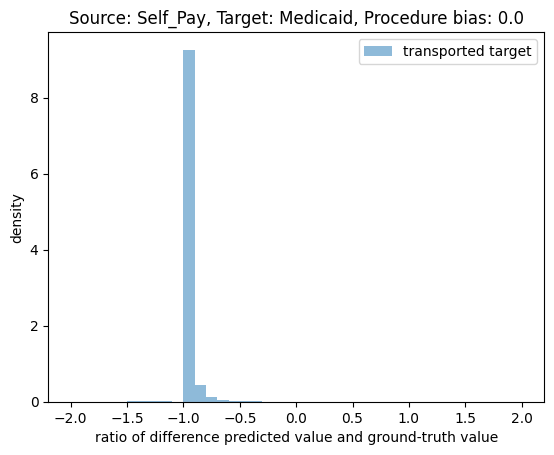

0.0024019215372297837

In [103]:
group_name = 'insurance'
group_1 = 'Self_Pay'
group_2 = 'Medicaid'
ratio_bound = 2

entire_proc(group_name, group_1, group_2, ratio_bound=ratio_bound)

target bias is 0.0024019215372297837


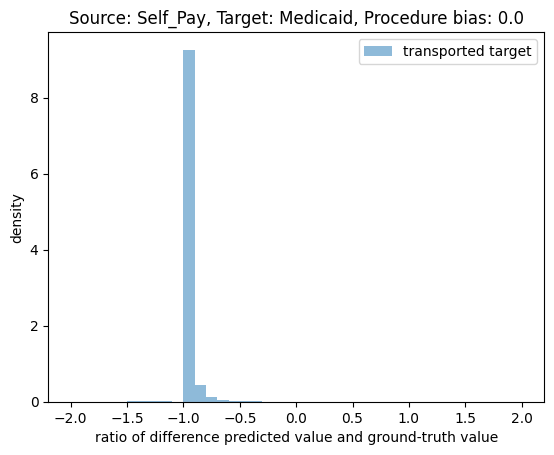

0.0024019215372297837

In [105]:
group_1, group_2 = group_2, group_1

entire_proc(group_name, group_1, group_2, ratio_bound=ratio_bound)